# Programming Assignment 1
## KNN and Decision Tree

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Matrícula: 518659


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions

## Metrics

In [2]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

    right_prediction = y_true == y_pred
    accuracy = right_prediction.sum() / len(y_true)
    return accuracy

def recall(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,0] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    recall = right_prediction.sum() / len(array)
    return recall

def precision(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    array = np.hstack([y_true, y_pred])
    array = array[array[:,1] == 1]
    
    right_prediction = array[:, 0] == array[:, 1]
    precision = right_prediction.sum() / len(array)

    return precision

def f1_score(y_true, y_pred):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    precision_score = precision(y_true, y_pred)
    recall_score = recall(y_true, y_pred)

    f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)

    return f1_score

## MinMaxScaler

In [3]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

## Standardization


In [4]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Cross Validation

In [5]:
def kfolds_cross_validation(data, n_folds=10, shuffle=True, random_state=12894):
    indexes = np.arange(data.shape[0])
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(indexes)

    slices = np.array_split(indexes, n_folds)
    all_elements = np.hstack(slices)   
    
    splits = []
    for i in range(n_folds):
        train_idx = all_elements[~np.isin(all_elements, slices[i])]
        test_idx = slices[i]

        splits.append((train_idx, test_idx))

    return splits

## Train Test Split

In [6]:
def train_test_split(data, train_size_perc, random_seed=264852):
    """
        Obs: Target variable must be the last one on the right
    """
    N = data.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    train_data = data[train_idx]
    test_data = data[test_idx]

    X_train = train_data[:, :-1]
    y_train = train_data[:, [-1]]

    X_test = test_data[:, :-1]
    y_test = test_data[:, [-1]]

    return X_train, X_test, y_train, y_test


## Do Cross Validation and Get Metrics

In [7]:
def do_cv_and_get_metrics(classifier, cv_splits, X_train, y_train, X_test, title='Classifier', scaler=None):

    X_train = X_train.copy()
    y_train = y_train.copy()
    X_test = X_test.copy()

    train_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }

    valid_metrics = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1_score': []
    }
    # Reporting results
    print('#' + f'{title}'.center(60, '-') + '#')

    print('\n---> Validation Folds Metrics')
    print('Fold\tAccuracy\tRecall\t\tPrecision\tF1-Score')
    count_fold = 1
    for train_idx, val_idx in cv_splits:
        # Spliting data
        X_train_cv = X_train[train_idx, :]
        y_train_cv = y_train[train_idx, :]
        X_val_cv = X_train[val_idx, :]
        y_val_cv = y_train[val_idx, :]

        # Scaling if have scaler argument
        if scaler is not None:
            X_train_cv = scaler.fit_transform(X_train_cv)
            X_val_cv = scaler.transform(X_val_cv)

        # Training Model
        classifier.fit(X_train_cv, y_train_cv.ravel())

        # Predictions
        y_train_cv_pred = classifier.predict(X_train_cv)
        y_val_cv_pred = classifier.predict(X_val_cv)

        # Storing metrics
        train_metrics['accuracy'].append(accuracy(y_train_cv, y_train_cv_pred))
        train_metrics['recall'].append(recall(y_train_cv, y_train_cv_pred))
        train_metrics['precision'].append(precision(y_train_cv, y_train_cv_pred))
        train_metrics['f1_score'].append(f1_score(y_train_cv, y_train_cv_pred))

        valid_metrics['accuracy'].append(accuracy(y_val_cv, y_val_cv_pred))
        valid_metrics['recall'].append(recall(y_val_cv, y_val_cv_pred))
        valid_metrics['precision'].append(precision(y_val_cv, y_val_cv_pred))
        valid_metrics['f1_score'].append(f1_score(y_val_cv, y_val_cv_pred))

        print('{0:.0f}\t{1:.4f}  \t{2:.4f}\t\t{3:.4f}   \t{4:.4f}'.format(
                count_fold,
                valid_metrics['accuracy'][-1], 
                valid_metrics['recall'][-1],
                valid_metrics['precision'][-1],
                valid_metrics['f1_score'][-1]
            )
        )
        count_fold+=1


    print('\n--->\tTraining Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['accuracy']), 
        np.std(train_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(train_metrics['recall']), 
        np.std(train_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['precision']), 
        np.std(train_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(train_metrics['f1_score']), 
        np.std(train_metrics['f1_score']))
    )

    print('\n--->\tValidation Metrics')

    print('Accuracy Mean:     \t{0:.4f} | Accuracy Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['accuracy']), 
        np.std(valid_metrics['accuracy']))
    )
    print('Recall Mean:     \t{0:.4f} | Recall Std:       \t{1:.4f}'.format(
        np.mean(valid_metrics['recall']), 
        np.std(valid_metrics['recall']))
    )
    print('Precision Mean:     \t{0:.4f} | Precision Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['precision']), 
        np.std(valid_metrics['precision']))
    )
    print('F1 Score Mean:     \t{0:.4f} | F1 Score Std:   \t{1:.4f}'.format(
        np.mean(valid_metrics['f1_score']), 
        np.std(valid_metrics['f1_score']))
    )

    print('\n--->\tTest Metrics')

    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.ravel())
    y_test_pred = classifier.predict(X_test)

    print('Accuracy:     \t{0:.4f}'.format(accuracy(y_test, y_test_pred)))
    print('Recall:     \t{0:.4f}'.format(recall(y_test, y_test_pred)))
    print('Precision:     \t{0:.4f}'.format(precision(y_test, y_test_pred)))
    print('F1 Score:     \t{0:.4f}'.format(f1_score(y_test, y_test_pred)))


# Task 1 - KNN

In [8]:
data = np.genfromtxt('../data/kc2.csv', delimiter=',')
print('Shape:', data.shape)
data[:3, :]


Shape: (522, 22)


array([[1.1000000e+00, 1.4000000e+00, 1.4000000e+00, 1.4000000e+00,
        1.3000000e+00, 1.3000000e+00, 1.3000000e+00, 1.3000000e+00,
        1.3000000e+00, 1.3000000e+00, 1.3000000e+00, 1.3000000e+00,
        2.0000000e+00, 2.0000000e+00, 2.0000000e+00, 2.0000000e+00,
        1.2000000e+00, 1.2000000e+00, 1.2000000e+00, 1.2000000e+00,
        1.4000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [4.1500000e+02, 5.9000000e+01, 5.0000000e+01, 5.1000000e+01,
        1.1590000e+03, 8.4113100e+03, 1.0000000e-02, 1.0353000e+02,
        8.1240000e+01, 8.7084858e+05, 2.8000000e+00, 4.8380480e+04,
        3.5900000e+02, 3.5000000e+01, 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 0.8, random_seed=466852)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X_train shape: (417, 21)
y_train shape: (417, 1)
X_test shape: (105, 21)
y_test shape: (105, 1)


In [19]:
class MyKNN():
    def __init__(self, k_neighbours, distance='euclidian'):
        self.fitted = False
        self.K = k_neighbours
        self.distance = distance

    def get_cov_matrix(self):
        
        mu = np.mean(self.X, axis=0).reshape(-1, 1)
        
        n_features = self.X.shape[1]
        n_rows = self.X.shape[0]
        sigma=np.zeros((n_features, n_features))

        for i in range(n_rows):
            x_i = self.X[i,:].reshape(n_features, 1)
            sigma += (x_i-mu) @ (x_i-mu).T

        return sigma/(n_rows-1)

    def euclidian_distance(self, i, j):
        distances = np.sqrt(np.sum((i - j)**2, axis=1))
        return distances.reshape(-1, 1)

    def mahalanobis_distance(self, i, j, sigma_inv):
        distances = np.sqrt(np.diag(np.dot(np.dot((i-j), sigma_inv), (i-j).T)))
        return distances.reshape(-1, 1)

    def fit(self, X, y):
        self.X = X
        self.y = y.reshape(-1, 1)

    def get_more_frequently(self, arr):
        unique, counts = np.unique(arr, return_counts=True)
        return unique[np.argmax(counts)]

    def predict(self, X):
        preds = []
        for i in range(len(X)):
            if self.distance == 'euclidian':
                self.distances = self.euclidian_distance(X[[i], :], self.X)
            if self.distance == 'mahalanobis':
                sigma_inv = np.linalg.pinv(np.cov(self.X.T))
                sigma_inv = np.linalg.pinv(self.get_cov_matrix())
                self.distances  = self.mahalanobis_distance(
                    X[[i], :], 
                    self.X, 
                    sigma_inv
                )
                
            knn = np.hstack([self.distances, self.y])
            knn = knn[np.lexsort((knn[:,1], knn[:,0]))]
            preds.append(self.get_more_frequently(knn[:self.K, 1]))

        return np.array(preds).reshape(-1, 1)

## K=5 and Euclidian Distance

In [20]:
my_knn = MyKNN(5)

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

do_cv_and_get_metrics(
    classifier=my_knn, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    scaler=MinMaxScaler(),
    title=' My KNN - Euclidian Distance - K=5 '
)

#------------ My KNN - Euclidian Distance - K=5 -------------#

---> Validation Folds Metrics
Fold	Accuracy	Recall		Precision	F1-Score
1	0.8333  	0.7000		0.6364   	0.6667
2	0.8095  	0.2222		0.6667   	0.3333
3	0.7857  	0.2500		0.4000   	0.3077
4	0.8810  	0.7143		0.6250   	0.6667
5	0.8095  	0.4000		0.2857   	0.3333
6	0.7857  	0.5000		0.5556   	0.5263
7	0.8095  	0.3000		0.7500   	0.4286
8	0.8049  	0.5833		0.7000   	0.6364
9	0.8537  	0.5000		0.6667   	0.5714
10	0.8780  	0.3333		0.6667   	0.4444

--->	Training Metrics
Accuracy Mean:     	0.8756 | Accuracy Std:   	0.0066
Recall Mean:     	0.5435 | Recall Std:       	0.0214
Precision Mean:     	0.7791 | Precision Std:   	0.0264
F1 Score Mean:     	0.6402 | F1 Score Std:   	0.0215

--->	Validation Metrics
Accuracy Mean:     	0.8251 | Accuracy Std:   	0.0332
Recall Mean:     	0.4503 | Recall Std:       	0.1690
Precision Mean:     	0.5953 | Precision Std:   	0.1372
F1 Score Mean:     	0.4915 | F1 Score Std:   	0.1341

--->	Test Metrics
Accuracy:

In [21]:
# TO CHECK
from sklearn.neighbors import KNeighborsClassifier
sk_knn = KNeighborsClassifier(5)

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

do_cv_and_get_metrics(
    classifier=sk_knn, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    scaler=MinMaxScaler(),
    title=' Sklearn KNN - Euclidian Distance - K=5 '
)

#---------- Sklearn KNN - Euclidian Distance - K=5 ----------#

---> Validation Folds Metrics
Fold	Accuracy	Recall		Precision	F1-Score
1	0.8333  	0.7000		0.6364   	0.6667
2	0.8095  	0.2222		0.6667   	0.3333
3	0.7857  	0.2500		0.4000   	0.3077
4	0.8810  	0.7143		0.6250   	0.6667
5	0.8095  	0.4000		0.2857   	0.3333
6	0.7857  	0.5000		0.5556   	0.5263
7	0.8095  	0.3000		0.7500   	0.4286
8	0.8049  	0.5833		0.7000   	0.6364
9	0.8537  	0.5000		0.6667   	0.5714
10	0.8780  	0.3333		0.6667   	0.4444

--->	Training Metrics
Accuracy Mean:     	0.8756 | Accuracy Std:   	0.0066
Recall Mean:     	0.5435 | Recall Std:       	0.0214
Precision Mean:     	0.7791 | Precision Std:   	0.0264
F1 Score Mean:     	0.6402 | F1 Score Std:   	0.0215

--->	Validation Metrics
Accuracy Mean:     	0.8251 | Accuracy Std:   	0.0332
Recall Mean:     	0.4503 | Recall Std:       	0.1690
Precision Mean:     	0.5953 | Precision Std:   	0.1372
F1 Score Mean:     	0.4915 | F1 Score Std:   	0.1341

--->	Test Metrics
Accuracy:

## K=5 and Mahalanobis Distance

In [22]:
my_knn = MyKNN(5, distance='mahalanobis')

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

do_cv_and_get_metrics(
    classifier=my_knn, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    scaler=MinMaxScaler(),
    title=' My KNN - Mahalanobis Distance - K=5 '
)

#----------- My KNN - Mahalanobis Distance - K=5 ------------#

---> Validation Folds Metrics
Fold	Accuracy	Recall		Precision	F1-Score
1	0.8810  	0.6000		0.8571   	0.7059
2	0.7857  	0.1111		0.5000   	0.1818
3	0.8333  	0.2500		0.6667   	0.3636
4	0.9048  	0.4286		1.0000   	0.6000
5	0.8095  	0.2000		0.2000   	0.2000
6	0.8333  	0.4000		0.8000   	0.5333
7	0.8571  	0.5000		0.8333   	0.6250
8	0.7805  	0.4167		0.7143   	0.5263
9	0.8293  	0.3750		0.6000   	0.4615
10	0.9024  	0.3333		1.0000   	0.5000

--->	Training Metrics
Accuracy Mean:     	0.8543 | Accuracy Std:   	0.0078
Recall Mean:     	0.3958 | Recall Std:       	0.0347
Precision Mean:     	0.7811 | Precision Std:   	0.0276
F1 Score Mean:     	0.5246 | F1 Score Std:   	0.0332

--->	Validation Metrics
Accuracy Mean:     	0.8417 | Accuracy Std:   	0.0420
Recall Mean:     	0.3615 | Recall Std:       	0.1368
Precision Mean:     	0.7171 | Precision Std:   	0.2304
F1 Score Mean:     	0.4698 | F1 Score Std:   	0.1649

--->	Test Metrics
Accuracy:

In [23]:
# TO CHECK
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

sk_knn = KNeighborsClassifier(5, metric='mahalanobis', metric_params={'VI': np.linalg.pinv(np.cov(X_train_scaled.T))})

sk_knn.fit(X_train_scaled, y_train.ravel())

X_test_scaled = scaler.transform(X_test)
y_test_pred = sk_knn.predict(X_test_scaled)

print('SKLEARN - KNN with Mahalanobis Distance (To check)')
print('\n--->\tTest Metrics')
print('Accuracy:     \t{0:.4f}'.format(accuracy(y_test, y_test_pred)))
print('Recall:     \t{0:.4f}'.format(recall(y_test, y_test_pred)))
print('Precision:     \t{0:.4f}'.format(precision(y_test, y_test_pred)))
print('F1 Score:     \t{0:.4f}'.format(f1_score(y_test, y_test_pred)))

SKLEARN - KNN with Mahalanobis Distance (To check)

--->	Test Metrics
Accuracy:     	0.8190
Recall:     	0.2273
Precision:     	0.7143
F1 Score:     	0.3448


## K=1 and Euclidian Distance

In [24]:
my_knn = MyKNN(1)

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

do_cv_and_get_metrics(
    classifier=my_knn, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    scaler=MinMaxScaler(),
    title=' My KNN - Euclidian Distance - K=1 '
)

#------------ My KNN - Euclidian Distance - K=1 -------------#

---> Validation Folds Metrics
Fold	Accuracy	Recall		Precision	F1-Score
1	0.8095  	0.6000		0.6000   	0.6000
2	0.7619  	0.2222		0.4000   	0.2857
3	0.8333  	0.5000		0.5714   	0.5333
4	0.8571  	0.5714		0.5714   	0.5714
5	0.7381  	0.2000		0.1250   	0.1538
6	0.8571  	0.6000		0.7500   	0.6667
7	0.8095  	0.5000		0.6250   	0.5556
8	0.7317  	0.7500		0.5294   	0.6207
9	0.8293  	0.5000		0.5714   	0.5333
10	0.8293  	0.1667		0.3333   	0.2222

--->	Training Metrics
Accuracy Mean:     	0.9832 | Accuracy Std:   	0.0024
Recall Mean:     	0.9177 | Recall Std:       	0.0113
Precision Mean:     	1.0000 | Precision Std:   	0.0000
F1 Score Mean:     	0.9570 | F1 Score Std:   	0.0061

--->	Validation Metrics
Accuracy Mean:     	0.8057 | Accuracy Std:   	0.0438
Recall Mean:     	0.4610 | Recall Std:       	0.1873
Precision Mean:     	0.5077 | Precision Std:   	0.1680
F1 Score Mean:     	0.4743 | F1 Score Std:   	0.1729

--->	Test Metrics
Accuracy:

In [25]:
# TO CHECK
from sklearn.neighbors import KNeighborsClassifier
sk_knn = KNeighborsClassifier(1)

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

do_cv_and_get_metrics(
    classifier=sk_knn, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    scaler=MinMaxScaler(),
    title=' Sklearn KNN - Euclidian Distance - K=1 '
)

#---------- Sklearn KNN - Euclidian Distance - K=1 ----------#

---> Validation Folds Metrics
Fold	Accuracy	Recall		Precision	F1-Score
1	0.7857  	0.6000		0.5455   	0.5714
2	0.7619  	0.2222		0.4000   	0.2857
3	0.8095  	0.5000		0.5000   	0.5000
4	0.8095  	0.5714		0.4444   	0.5000
5	0.7143  	0.2000		0.1111   	0.1429
6	0.8095  	0.6000		0.6000   	0.6000
7	0.7857  	0.5000		0.5556   	0.5263
8	0.7561  	0.8333		0.5556   	0.6667
9	0.7317  	0.5000		0.3636   	0.4211
10	0.7561  	0.1667		0.1667   	0.1667

--->	Training Metrics
Accuracy Mean:     	0.9766 | Accuracy Std:   	0.0063
Recall Mean:     	0.9699 | Recall Std:       	0.0084
Precision Mean:     	0.9206 | Precision Std:   	0.0320
F1 Score Mean:     	0.9442 | F1 Score Std:   	0.0146

--->	Validation Metrics
Accuracy Mean:     	0.7720 | Accuracy Std:   	0.0319
Recall Mean:     	0.4694 | Recall Std:       	0.2013
Precision Mean:     	0.4242 | Precision Std:   	0.1596
F1 Score Mean:     	0.4381 | F1 Score Std:   	0.1721

--->	Test Metrics
Accuracy:

The slight differences in metrics occur because Sklearn chooses randonly the first label with the minimum distance of a specific X. If we get more than one example with minimum distance, it might diverge for my implementation. In my implementation i am always using the negative class if it is contained in the subset of minimum distances.

## K=1 and Mahalanobis Distance

In [26]:
my_knn = MyKNN(1, distance='mahalanobis')

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

do_cv_and_get_metrics(
    classifier=my_knn, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    scaler=MinMaxScaler(),
    title=' My KNN - Mahalanobis Distance - K=1 '
)

#----------- My KNN - Mahalanobis Distance - K=1 ------------#

---> Validation Folds Metrics
Fold	Accuracy	Recall		Precision	F1-Score
1	0.9048  	0.8000		0.8000   	0.8000
2	0.7381  	0.1111		0.2500   	0.1538
3	0.8810  	0.5000		0.8000   	0.6154
4	0.8095  	0.2857		0.4000   	0.3333
5	0.8333  	0.4000		0.3333   	0.3636
6	0.8095  	0.3000		0.7500   	0.4286
7	0.7619  	0.2000		0.5000   	0.2857
8	0.7317  	0.4167		0.5556   	0.4762
9	0.8293  	0.6250		0.5556   	0.5882
10	0.8537  	0.1667		0.5000   	0.2500

--->	Training Metrics
Accuracy Mean:     	0.9832 | Accuracy Std:   	0.0024
Recall Mean:     	0.9177 | Recall Std:       	0.0113
Precision Mean:     	1.0000 | Precision Std:   	0.0000
F1 Score Mean:     	0.9570 | F1 Score Std:   	0.0061

--->	Validation Metrics
Accuracy Mean:     	0.8153 | Accuracy Std:   	0.0549
Recall Mean:     	0.3805 | Recall Std:       	0.2045
Precision Mean:     	0.5444 | Precision Std:   	0.1814
F1 Score Mean:     	0.4295 | F1 Score Std:   	0.1848

--->	Test Metrics
Accuracy:

In [27]:
# TO CHECK
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

sk_knn = KNeighborsClassifier(1, metric='mahalanobis', metric_params={'VI': np.linalg.pinv(np.cov(X_train_scaled.T))})

sk_knn.fit(X_train_scaled, y_train.ravel())

X_test_scaled = scaler.transform(X_test)
y_test_pred = sk_knn.predict(X_test_scaled)

print('SKLEARN - KNN with Mahalanobis Distance and K=1 (To check)')
print('\n--->\tTest Metrics')
print('Accuracy:     \t{0:.4f}'.format(accuracy(y_test, y_test_pred)))
print('Recall:     \t{0:.4f}'.format(recall(y_test, y_test_pred)))
print('Precision:     \t{0:.4f}'.format(precision(y_test, y_test_pred)))
print('F1 Score:     \t{0:.4f}'.format(f1_score(y_test, y_test_pred)))

SKLEARN - KNN with Mahalanobis Distance and K=1 (To check)

--->	Test Metrics
Accuracy:     	0.8190
Recall:     	0.4545
Precision:     	0.5882
F1 Score:     	0.5128


# Task 2 - Decision Tree

In [28]:
data = np.genfromtxt('../data/kc2.csv', delimiter=',')
print('Shape:', data.shape)
data[:3, :]

Shape: (522, 22)


array([[1.1000000e+00, 1.4000000e+00, 1.4000000e+00, 1.4000000e+00,
        1.3000000e+00, 1.3000000e+00, 1.3000000e+00, 1.3000000e+00,
        1.3000000e+00, 1.3000000e+00, 1.3000000e+00, 1.3000000e+00,
        2.0000000e+00, 2.0000000e+00, 2.0000000e+00, 2.0000000e+00,
        1.2000000e+00, 1.2000000e+00, 1.2000000e+00, 1.2000000e+00,
        1.4000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [4.1500000e+02, 5.9000000e+01, 5.0000000e+01, 5.1000000e+01,
        1.1590000e+03, 8.4113100e+03, 1.0000000e-02, 1.0353000e+02,
        8.1240000e+01, 8.7084858e+05, 2.8000000e+00, 4.8380480e+04,
        3.5900000e+02, 3.5000000e+01, 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    data, 0.9, random_seed=466851)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X_train shape: (469, 21)
y_train shape: (469, 1)
X_test shape: (53, 21)
y_test shape: (53, 1)


In [37]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

## Gini Impurity

In [38]:
decision_tree = DecisionTreeClassifier(criterion='gini')

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

do_cv_and_get_metrics(
    classifier=decision_tree, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    title=' Decision Tree - Gini Impurity '
)

#-------------- Decision Tree - Gini Impurity ---------------#

---> Validation Folds Metrics
Fold	Accuracy	Recall		Precision	F1-Score
1	0.8511  	0.5556		0.6250   	0.5882
2	0.7660  	0.3333		0.3750   	0.3529
3	0.7660  	0.3000		0.4286   	0.3529
4	0.8298  	0.5000		0.5000   	0.5000
5	0.6383  	0.1667		0.2222   	0.1905
6	0.7872  	0.5000		0.3000   	0.3750
7	0.8511  	0.4444		0.6667   	0.5333
8	0.7021  	0.3846		0.4545   	0.4167
9	0.7447  	0.3636		0.4444   	0.4000
10	0.8478  	0.1667		0.3333   	0.2222

--->	Training Metrics
Accuracy Mean:     	0.9851 | Accuracy Std:   	0.0015
Recall Mean:     	0.9247 | Recall Std:       	0.0076
Precision Mean:     	1.0000 | Precision Std:   	0.0000
F1 Score Mean:     	0.9609 | F1 Score Std:   	0.0041

--->	Validation Metrics
Accuracy Mean:     	0.7784 | Accuracy Std:   	0.0671
Recall Mean:     	0.3715 | Recall Std:       	0.1276
Precision Mean:     	0.4350 | Precision Std:   	0.1311
F1 Score Mean:     	0.3932 | F1 Score Std:   	0.1198

--->	Test Metrics
Accuracy:

C:\Users\edyalenquer\AppData\Local\Temp\ipykernel_16720\3660250042.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


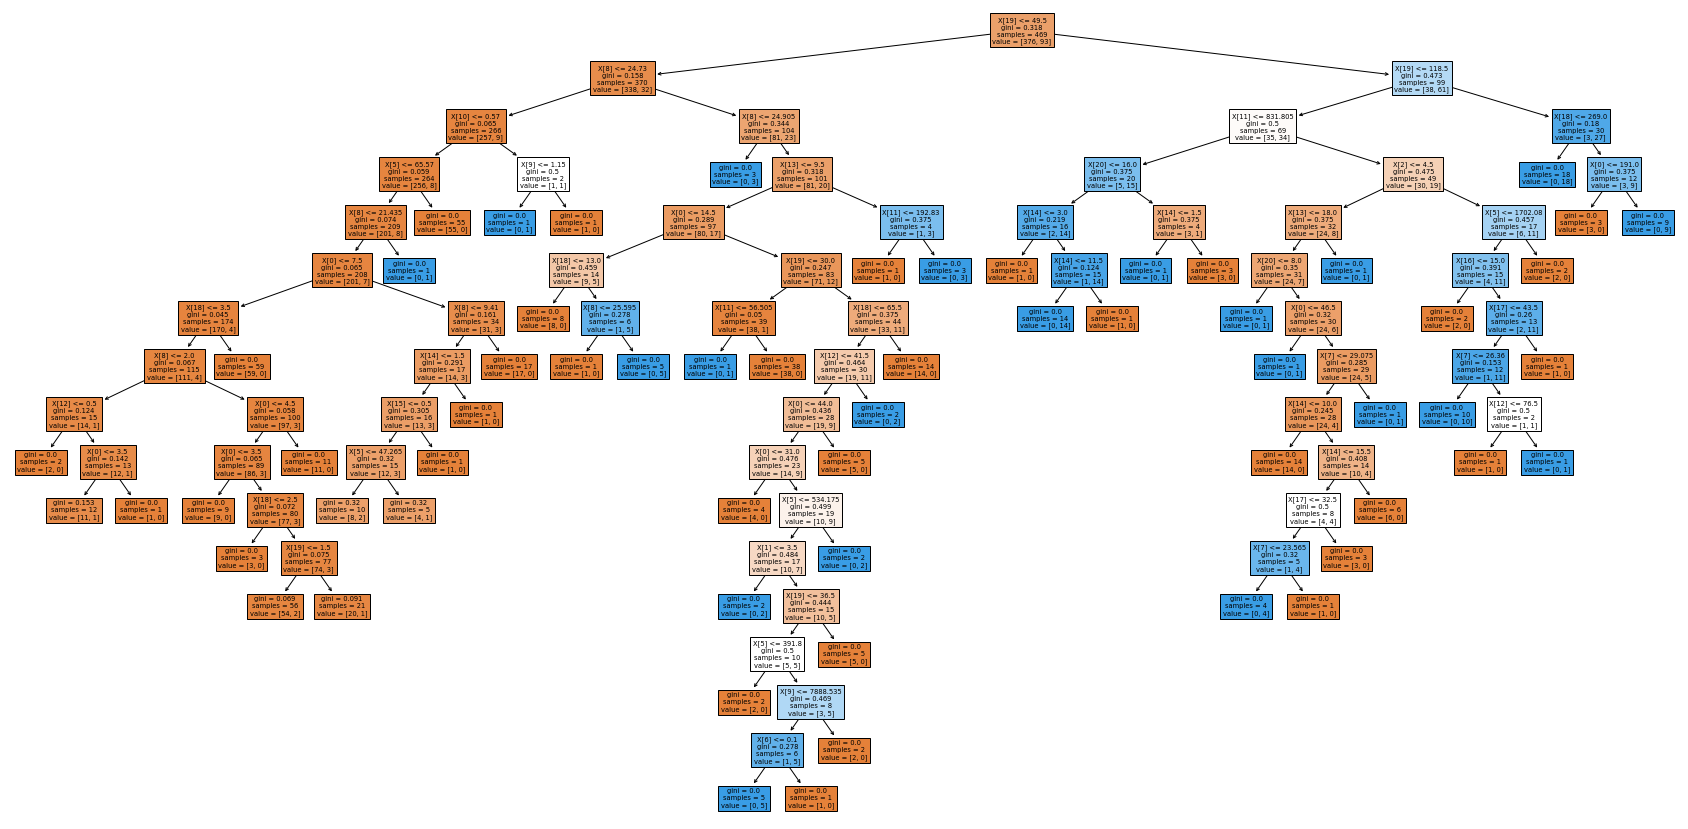

In [39]:
fig = plt.figure(figsize=(30,15))
tree.plot_tree(decision_tree, filled=True)
fig.show()

## Entropy

In [40]:
decision_tree = DecisionTreeClassifier(criterion='entropy')

cv_splits = kfolds_cross_validation(
    data=X_train,
    n_folds=10,
    shuffle=True
)

do_cv_and_get_metrics(
    classifier=decision_tree, 
    cv_splits=cv_splits, 
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test,
    title=' Decision Tree - Entropy '
)

#----------------- Decision Tree - Entropy ------------------#

---> Validation Folds Metrics
Fold	Accuracy	Recall		Precision	F1-Score
1	0.8511  	0.6667		0.6000   	0.6316
2	0.7660  	0.2222		0.3333   	0.2667
3	0.7660  	0.5000		0.4545   	0.4762
4	0.7660  	0.3750		0.3333   	0.3529
5	0.6809  	0.3333		0.3636   	0.3478
6	0.8298  	0.3333		0.3333   	0.3333
7	0.8511  	0.5556		0.6250   	0.5882
8	0.8085  	0.6923		0.6429   	0.6667
9	0.7447  	0.0909		0.3333   	0.1429
10	0.8478  	0.3333		0.4000   	0.3636

--->	Training Metrics
Accuracy Mean:     	0.9851 | Accuracy Std:   	0.0015
Recall Mean:     	0.9247 | Recall Std:       	0.0076
Precision Mean:     	1.0000 | Precision Std:   	0.0000
F1 Score Mean:     	0.9609 | F1 Score Std:   	0.0041

--->	Validation Metrics
Accuracy Mean:     	0.7912 | Accuracy Std:   	0.0533
Recall Mean:     	0.4103 | Recall Std:       	0.1819
Precision Mean:     	0.4419 | Precision Std:   	0.1241
F1 Score Mean:     	0.4170 | F1 Score Std:   	0.1605

--->	Test Metrics
Accuracy:

C:\Users\edyalenquer\AppData\Local\Temp\ipykernel_16720\3660250042.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


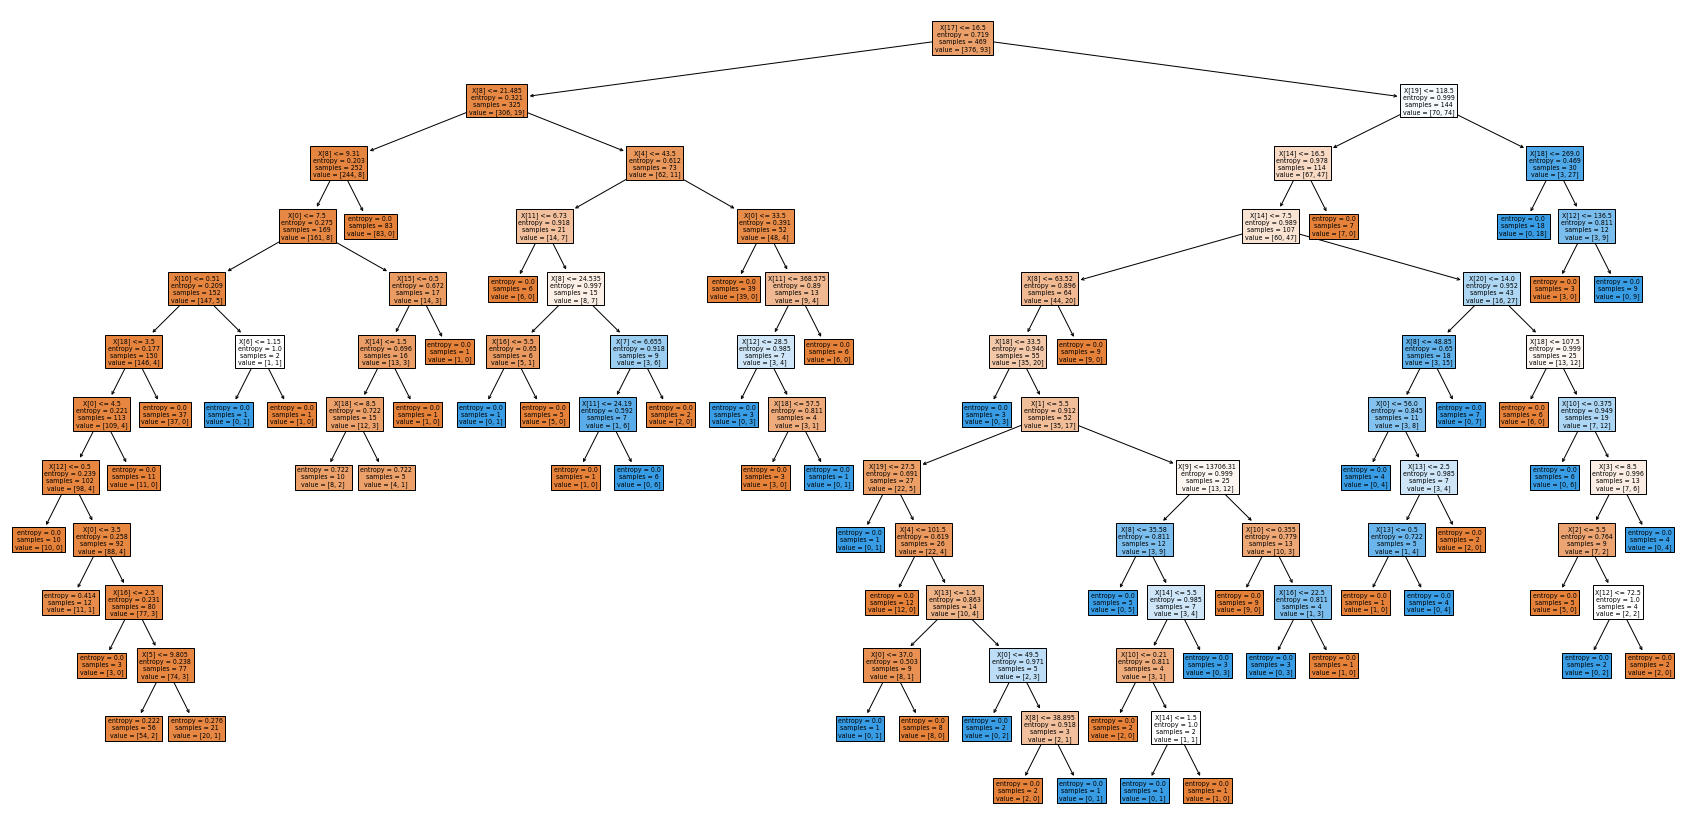

In [41]:
fig = plt.figure(figsize=(30,15))
tree.plot_tree(decision_tree, filled=True)
fig.show()